In [43]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup,AutoTokenizer
import pytorch_lightning as pl
from torchmetrics.functional.classification import accuracy,  multilabel_auroc as auroc
from torchmetrics import F1Score as f1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [44]:
BERT_MODEL_NAME = "airesearch/wangchanberta-base-att-spm-uncased"

In [45]:
import pandas as pd

df = pd.read_csv('cleaned_data.csv',index_col=False)
df

,Unnamed: 0,ticket_id,type,comment,ถนน,ทางเท้า,แสงสว่าง,ความปลอดภัย,น้ำท่วม,ความสะอาด,...,ป้าย,สัตว์จรจัด,PM25,สอบถาม,เสนอแนะ,คนจรจัด,การเดินทาง,ห้องน้ำ,ป้ายจราจร,labels
0,0,2021-BEJ9PP,['ถนน'],สะพานลอยกีดขวางทางเท้า ถนนเล็ก ควรทำเป็นทางข้า...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,2021-DDF9VX,"['คลอง', 'ความปลอดภัย', 'ทางเท้า']",ฟุตบาทยุบ และแคบมาก อันตรายที่จะพลัดตกลงคลองที...,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,2,2022-8TN97P,['จราจร'],เสาไฟจราจรเอียงจะล้ม,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,3,2022-GPUWCP,"['สายไฟ', 'ต้นไม้']",ต้นไม้สู้ชนสายไฟ,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
4,4,2022-KNYYC3,"['คลอง', 'ความสะอาด']",การทิ้งขยะลงในลำคลอง,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207084,208671,2023-4989VN,"['ถนน', 'คลอง']",📢🔊🌳🍃🎋แจ้ง มีวัชพืช เลื้อยพัน และไต่ระดับขึ้นสู...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
207085,208672,UNWWLC,"['เสียงรบกวน', 'ถนน']",‘กรุณาอ่านข้อมูลบรรยายประกอบการปักหมุด’\n* ปัญ...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
207086,208673,PT24KT,['สัตว์จรจัด'],ปัญหา : ช่วยจัดการกับนกพิราบ จำนวนมาก\nจุดสังเ...,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
207087,208674,2023-GL4KWC,['ทางเท้า'],ทางเท้าแบบนี้สภาพไม่ดีเลย กรุณาปรับปรุงโดยด่วน,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [46]:
df = df.drop(columns=['Unnamed: 0'])

In [47]:
df = df.sample(200)

In [48]:
df

,ticket_id,type,comment,ถนน,ทางเท้า,แสงสว่าง,ความปลอดภัย,น้ำท่วม,ความสะอาด,กีดขวาง,...,ป้าย,สัตว์จรจัด,PM25,สอบถาม,เสนอแนะ,คนจรจัด,การเดินทาง,ห้องน้ำ,ป้ายจราจร,labels
141823,2022-FXCB7Q,['แสงสว่าง'],ไฟฟ้าตรงทางเดินริมคลองมันไม่ติดมาเป็นเวลาหลายป...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
116002,2022-CYKPR6,['ทางเท้า'],สิ่งของกั้นที่จอดรถ ทั้งฟุตบาทและทางเท้าข้างล่าง,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
33014,2022-DE97ZE,['ทางเท้า'],พื้นฟุตบาทบริเวณ BTS บางหว้า ทางออก 1 และ 2 มี...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
137818,2022-797GPT,['สายไฟ'],สายไฟหย่อนลงมาขวางทางเดินเท้าครับ,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
10817,2022-38AZNZ,['น้ำท่วม'],น้ำท่วมสูง,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42029,FRLKLZ,['สัตว์จรจัด'],หมาเห่า รบกวนมากค่ะ หมาตัวเล็ก และกลิ่นขี้หมาโ...,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
134861,2022-8R6YEF,['สัตว์จรจัด'],ทำหมันแมวจร,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
132833,2022-GCBHEU,"['สะพาน', 'คลอง']",ตั้งแต่หน้าหมู่บ้านถึงสะพานแห้งหมดแล้วข้ามสะพา...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
53967,2022-C6FLH8,['เสียงรบกวน'],แคมป์คนงานหลังหมู่บ้านอักษรา (เช้าจากซอยถัดจาก...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [49]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((190, 28), (10, 28))

In [50]:
tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

In [51]:
types = ['ถนน','ทางเท้า','แสงสว่าง','ความปลอดภัย','น้ำท่วม','ความสะอาด','กีดขวาง',
        'ท่อระบายน้ำ','สะพาน','จราจร','สายไฟ','คลอง','เสียงรบกวน','ต้นไม้','ร้องเรียน',
        'ป้าย','สัตว์จรจัด',"PM25",'สอบถาม','เสนอแนะ','คนจรจัด','การเดินทาง','ห้องน้ำ','ป้ายจราจร']

In [52]:
sample_row = df.iloc[16]
sample_comment = sample_row.comment
sample_labels = sample_row[types]
print(sample_comment)
print()
print(sample_labels.to_dict())

1. ทางพิเศษ มักจะมาก่อสร้างเวลากลางคืน ในฐานะผู้อาศัยใกล้ทางด่วน บางกรณีมีความเข้าใจว่าจำเป็นต้องทำในเวลาวิกาลเพราะสะดวกกว่า แต่ในบางกรณี ที่ไม่ได้ลงทำที่ผิวถนน ก็ควรจะเลือกเวลาอื่นที่รถสัญจรน้อยเช่นกัน เพื่อลดปัญหามลพิษทางเสียงยามวิกาลหรือไม่ การก่อสร้างแต่ละครั้งทางด่วนไม่ได้มีการประกาศหรือแจ้งแบบมีลายลักษณ์อักษร กับผู้อาศัยใกล้เคียงเลย รู้อีกทีคือตอนมาก่อสร้างแล้ว ต้องมาทนได้รับเสียงรบกวน ตั้งแต่ 23:00-04:00 ส่งผลให้คุณภาพชีวิตแย่ นอนไม่ได้

{'ถนน': 1, 'ทางเท้า': 0, 'แสงสว่าง': 0, 'ความปลอดภัย': 0, 'น้ำท่วม': 0, 'ความสะอาด': 0, 'กีดขวาง': 0, 'ท่อระบายน้ำ': 0, 'สะพาน': 0, 'จราจร': 0, 'สายไฟ': 0, 'คลอง': 0, 'เสียงรบกวน': 0, 'ต้นไม้': 0, 'ร้องเรียน': 0, 'ป้าย': 0, 'สัตว์จรจัด': 0, 'PM25': 0, 'สอบถาม': 0, 'เสนอแนะ': 0, 'คนจรจัด': 0, 'การเดินทาง': 0, 'ห้องน้ำ': 0, 'ป้ายจราจร': 0}


In [53]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [54]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [55]:
encoding["input_ids"].squeeze()[:20]

tensor([    5,  3428,    10,    75,   498,    10,  1591,    26,   966,   156,
         4426,    10,  8580,  2346,   991,  8684, 13249,   553,   372,  2799])

In [56]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['<s>', '▁1.', '▁', 'ทาง', 'พิเศษ', '▁', 'มักจะ', 'มา', 'ก่อสร้าง', 'เวลา', 'กลางคืน', '▁', 'ในฐานะผู้', 'อาศัย', 'ใกล้', 'ทางด่วน', '▁บาง', 'กรณี', 'มีความ', 'เข้าใจว่า']


In [58]:
MAX_TOKEN_COUNT = 512

In [59]:
class ToxicCommentsDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.comment
    labels = data_row[types]
    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [60]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [61]:
bert_model = BertModel.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', return_dict=True)


You are using a model of type camembert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing BertModel: ['roberta.encoder.layer.2.attention.self.value.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.output.dense.weight', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.11.attention.self.value.bias', 'roberta.encoder.layer.7.intermediate.dense.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.2.intermediate.dense.bias', 'roberta.encoder.layer.6.attention.output.dense.weight', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.10.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.self.value.bias', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder.

In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=8)

In [63]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [64]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [65]:
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-4.4773e-01, -1.4829e-01,  6.1274e-01,  ...,  9.1935e-01,
          -7.1762e-01,  9.9752e-01],
         [-6.0689e-01,  6.2310e-01, -2.8681e-01,  ...,  4.2197e-01,
           1.0650e-01,  1.2796e-01],
         [-1.3682e-01, -1.1065e-01,  5.5573e-01,  ...,  4.7925e-01,
          -1.5548e+00,  7.7126e-02],
         ...,
         [-7.7735e-01, -5.0141e-01,  9.9476e-01,  ...,  8.7856e-01,
          -1.3373e+00, -3.3711e-01],
         [-2.0743e-01, -1.2167e+00,  2.0887e-01,  ...,  1.1238e+00,
          -1.6144e-01,  2.8420e-01],
         [-5.7101e-01,  2.9514e-01,  1.0388e+00,  ...,  1.2022e+00,
          -3.2453e-01,  1.0080e+00]],

        [[-2.0190e-01,  6.4062e-02,  8.2502e-01,  ...,  7.8077e-01,
          -8.4780e-01,  1.3088e+00],
         [-6.4470e-01, -1.6259e-01,  1.1300e+00,  ..., -6.5792e-01,
          -5.8097e-01, -1.6095e-01],
         [-6.1005e-01,  5.6509e-01, -1.6551e-01,  ...,  1.5095e-01,
          -7.

In [66]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [67]:
class ToxicCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size
    )

In [68]:
BERT_MODEL_NAME = "airesearch/wangchanberta-base-att-spm-uncased"

In [69]:
N_EPOCHS = 10
BATCH_SIZE = 8
data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [70]:
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    print("hello")
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(types):
      class_roc_auc = auroc(predictions[:, i], labels[:, i],len(types))
      print("hello")
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


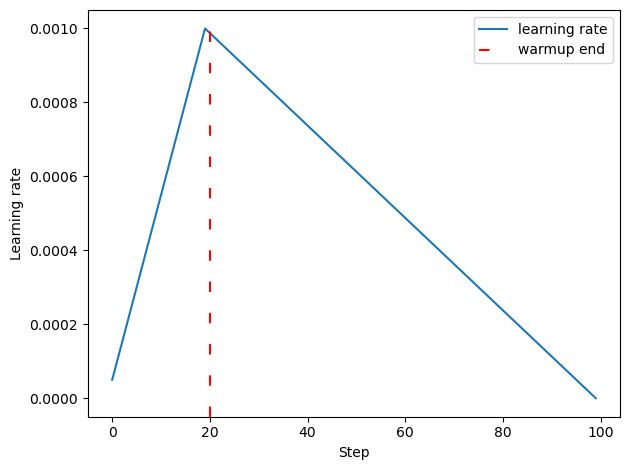

In [71]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout()

In [72]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [73]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(46, 230)

In [74]:
model = ToxicCommentTagger(
  n_classes=len(types),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

You are using a model of type camembert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing BertModel: ['roberta.encoder.layer.2.attention.self.value.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.output.dense.weight', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.11.attention.self.value.bias', 'roberta.encoder.layer.7.intermediate.dense.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.2.intermediate.dense.bias', 'roberta.encoder.layer.6.attention.output.dense.weight', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.10.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.self.value.bias', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder.

In [75]:
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)

In [76]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [77]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

In [78]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.4396, 0.5189, 0.4877, 0.5319, 0.4142, 0.5191, 0.5478, 0.5132, 0.4922,
         0.4821, 0.5069, 0.4351, 0.5166, 0.4892, 0.5289, 0.5514, 0.4543, 0.4614,
         0.5138, 0.4859, 0.5183, 0.5720, 0.5185, 0.5012],
        [0.4293, 0.5191, 0.4733, 0.5066, 0.3792, 0.5318, 0.5109, 0.5270, 0.5029,
         0.4978, 0.5026, 0.4574, 0.5133, 0.4917, 0.5458, 0.5580, 0.4894, 0.4701,
         0.5230, 0.4957, 0.4967, 0.5471, 0.4947, 0.4857],
        [0.4490, 0.5285, 0.4779, 0.4969, 0.3734, 0.5361, 0.5189, 0.4860, 0.4717,
         0.4661, 0.4895, 0.4693, 0.5247, 0.4625, 0.5293, 0.5525, 0.4897, 0.4457,
         0.5160, 0.4887, 0.4972, 0.5476, 0.4932, 0.5001],
        [0.4334, 0.5075, 0.4880, 0.4953, 0.3808, 0.5461, 0.5334, 0.5114, 0.4828,
         0.4715, 0.4871, 0.4561, 0.5203, 0.4933, 0.5325, 0.5553, 0.4856, 0.4419,
         0.5109, 0.4989, 0.4879, 0.5516, 0.4665, 0.4885],
        [0.4313, 0.5107, 0.4647, 0.5070, 0.3734, 0.5325, 0.5094, 0.5313, 0.4952,
         0.5050, 0.5053, 0.4582, 0.5098

In [79]:
criterion(predictions, sample_batch["labels"])

tensor(0.6868, grad_fn=<BinaryCrossEntropyBackward0>)

In [80]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [81]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [82]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [83]:
trainer = pl.Trainer(
  logger=logger,
  callbacks=[early_stopping_callback,checkpoint_callback],
  max_epochs=N_EPOCHS,
  gpus=0
)

c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [84]:
trainer.fit(model, data_module)


  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 105 M 
1 | classifier | Linear    | 18.5 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
105 M     Trainable params
0         Non-trainable params
105 M     Total params
421.051   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


hello
hello


c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\sern7\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\trainer.py:1600: PossibleUserWarning: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]